# Exercises Week 3 in 02506

Today we are going to do blob detection with scale space filtering.
<p align="center"> 
  <img src="./bone/bone_test_1.PNG" width="300" title="Artificially generated blobs">
</p>

## Imports

In [5]:
import numpy as np
import scipy 
from skimage.io import imread, imshow
from scipy.ndimage import gaussian_filter1d, gaussian_filter,minimum_filter, maximum_filter
import matplotlib.pyplot as plt
import cv2
from local_features import *
import random
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from skimage import color

## Exercise A) Compute features

### 1. Read in the image and display it.

Text(0.5, 1.0, 'Label')

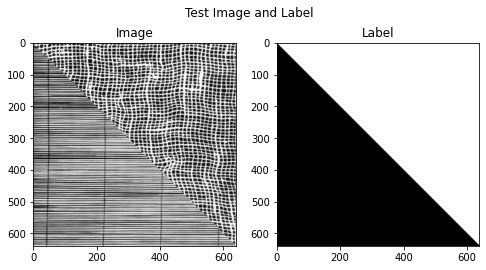

In [2]:
img = imread('./2labels/training.png').astype(float)
label = imread('./2labels/training_labels.png').astype(float)

fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(8, 4))
fig.suptitle('Test Image and Label')
ax1.imshow(img,cmap='Greys')
ax1.set_title("Image")
ax2.imshow(label,cmap='Greys')
ax2.set_title("Label")


### 2. Compute the feature image.

In [3]:
features = np.array(get_gauss_feat_im(img, sigma=5, normalize=True))


### 3. Inspect the feature image by displaying the layers. You can sample a few and look at them one at a time or you can display multiple images at once.

/tmp/ipykernel_630/3810631407.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ax[np.int(np.floor(i/5)),i%5].imshow(features[:,:,i],cmap='Greys')
/tmp/ipykernel_630/3810631407.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

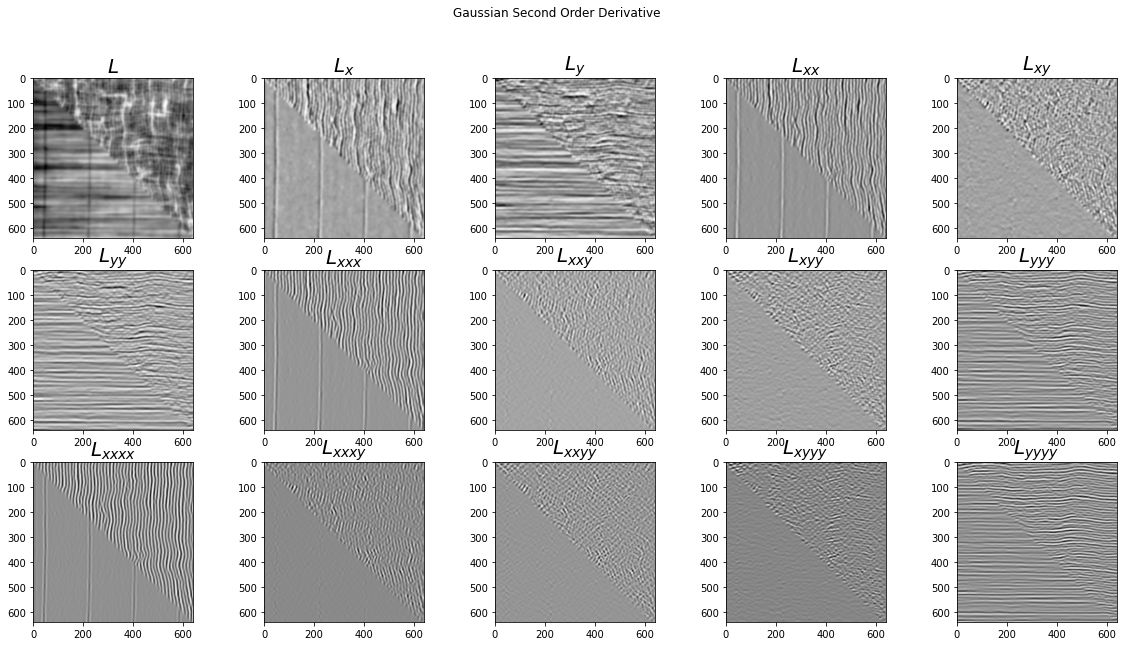

In [4]:
r,c,nfeat = np.shape(features)

titles = [r"$L$", r"$L_{x}$", r"$L_{y}$", r"$L_{xx}$", r"$L_{xy}$", r"$L_{yy}$", r"$L_{xxx}$", r"$L_{xxy}$", r"$L_{xyy}$", r"$L_{yyy}$",
r"$L_{xxxx}$", r"$L_{xxxy}$", r"$L_{xxyy}$", r"$L_{xyyy}$",r"$L_{yyyy}$"]

fig, ax = plt.subplots(3,5,figsize=(20,10))
fig.suptitle('Gaussian Second Order Derivative')
for i in range(nfeat):
    ax[np.int(np.floor(i/5)),i%5].imshow(features[:,:,i],cmap='Greys')
    ax[np.int(np.floor(i/5)),i%5].set_title(titles[i],size=20)

### 4. Since we will be clustering the features, you can transform the feature image of size $r \times c \times 15n$, where r is the rows, c is the columns, and n is the number of scales, into a 2D array of size $rc\times 15n$ where each row is a feature vector.

In [5]:
feat2d = np.reshape(features, [r*c,nfeat], order='C')
print(feat2d[15,:])
print(features[0,15,:])

[-1.48939741  0.34697008  0.07526344 -1.6086205   0.12661922  0.44885461
  0.08043503  0.76147733  1.08882421  0.35563769  2.1562944   0.07065416
  8.05783222 -0.63789472  1.62218822]
[-1.48939741  0.34697008  0.07526344 -1.6086205   0.12661922  0.44885461
  0.08043503  0.76147733  1.08882421  0.35563769  2.1562944   0.07065416
  8.05783222 -0.63789472  1.62218822]


## B) Prepare labels for clustering

Text(0.5, 1.0, 'Label')

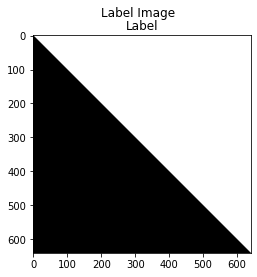

In [6]:
fig, (ax1) = plt.subplots(1, 1,figsize=(4, 4))
fig.suptitle('Label Image')
ax1.imshow(label,cmap='Greys')
ax1.set_title("Label")

## C) Build dictionary
### 1. Select a random subset of feature vectors with corresponding labels (you can use random permutation). If you choose e.g. 5000-10000 vectors, it should be sufficient for clustering.

In [7]:
nidx = 5000
random.seed(101)
idx = random.sample(range(0, r*c-1),nidx)
# We also have to reshape the labels accordingly
label2d = np.reshape(label, [r*c,1], order='C')
feat2dsmall = feat2d[idx,:]
label2dsmall = label2d[idx]

### 2. Use k-means to cluster the feature vectors into a number of clusters. You can choose e.g. 100-1000 clusters.

In [8]:
nclust = 100
kmeans = KMeans(n_clusters=nclust, init='k-means++', n_init=10, max_iter=300, tol=0.0001).fit(feat2dsmall)

### 3. Make an $n_l\times n_c$ array to store label probabilities, where $n_c$ is the number of cluster centers. Compute the probability of a cluster belonging to each of the labels using Eq. 3.2 and 3.3, and store the probabilities in the array.

In [9]:
unique_labels = np.unique(label2d)
nlabels = np.size(np.unique(label2d))
print(f"There are {nlabels} and {nclust} clusters")
print(kmeans)
prediction = kmeans.predict(feat2dsmall)
label_probs = np.zeros([nlabels,nclust])
for j in range(nclust):
    in_clust = prediction == j
    clust_size = sum(in_clust)
    for i in range(nlabels):
        label_probs[i,j] = np.sum(label2dsmall[in_clust] == unique_labels[i])/clust_size

There are 2 and 100 clusters
KMeans(n_clusters=100)


Text(0.5, 1.0, 'clusters')

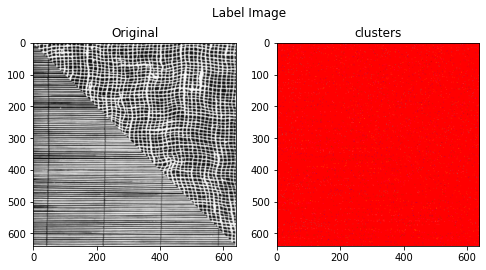

In [10]:
img_tmp = np.ones([r*c])
img_tmp[idx] = prediction
img_tmp = np.reshape(img_tmp,[r,c])
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(8,4))
fig.suptitle('Label Image')
ax1.imshow(img,cmap='Greys')
ax1.set_title("Original")
ax2.imshow(color.label2rgb(img_tmp))
ax2.set_title("clusters")

## D) Assign dictionary to test image
### 1. Compute a feature image from the test image.

In [11]:
testimg = imread('./2labels/test_easy.png').astype(float)
test_feat = np.array(get_gauss_feat_im(testimg, sigma=5, normalize=True))
test_feat2d = np.reshape(test_feat, [r*c,nfeat], order='C')

### 2. Use a nearest neighbor algorithm (knnsearch in MATLAB or Nearest Neighbors from Scikit Learn in Python) and find the nearest cluster for each feature in the image.

In [12]:
pred = kmeans.predict(test_feat2d)

### 3. Store the index of the nearest cluster center in an image of size $r\times c$.

Text(0.5, 1.0, 'clusters')

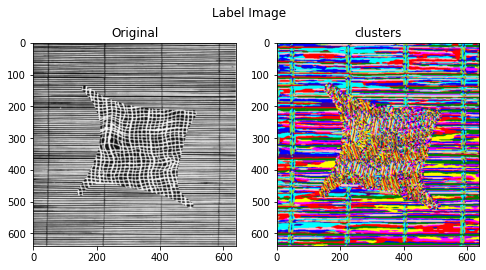

In [13]:
pred_img = np.reshape(pred,[r,c])

img_tmp = np.ones([r*c])
img_tmp[idx] = prediction
img_tmp = np.reshape(img_tmp,[r,c])
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(8,4))
fig.suptitle('Label Image')
ax1.imshow(testimg,cmap='Greys')
ax1.set_title("Original")
ax2.imshow(color.label2rgb(pred_img))
ax2.set_title("clusters")

## E) Compute probability image and segmentation
### 1. Create an $r\times c\times n_l$ probability image.
### 2. In each pixel you insert the probability of the cluster center (index is stored in the assignment image from before).

In [14]:
print(np.shape(pred_img))
print(r)
print(c)
prob_img = np.zeros([r,c,nlabels])
for i in range(r):
    for j in range(c):
        prob_img[i,j,:] = label_probs[:,pred_img[i,j]]

(640, 640)
640
640


### 3. Obtain a segmentation by selecting the most probable label in each pixel.

Text(0.5, 1.0, 'clusters')

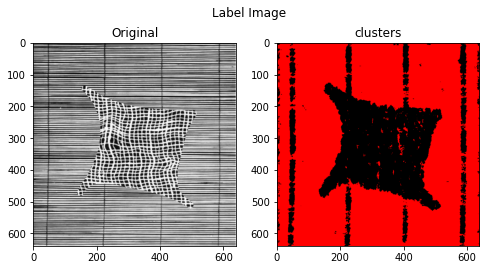

In [15]:
img_tmp = np.ones([r*c])
img_tmp[idx] = prediction
img_tmp = np.reshape(img_tmp,[r,c])
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(8,4))
fig.suptitle('Label Image')
ax1.imshow(testimg,cmap='Greys')
ax1.set_title("Original")
ax2.imshow(color.label2rgb(np.argmax(prob_img,2)))
ax2.set_title("clusters")

### 4. Try smoothing the probability image before selecting the most probable label.

Text(0.5, 1.0, 'clusters')

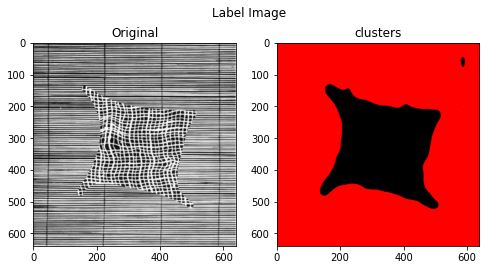

In [16]:
order = 0
sigma = 11
prob_img_smooth = prob_img

for i in range(nlabels):
    prob_img_smooth[:,:,i] = gaussian_filter(prob_img[:,:,i], sigma, order=order)

fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(8,4))
fig.suptitle('Label Image')
ax1.imshow(testimg,cmap='Greys')
ax1.set_title("Original")
ax2.imshow(color.label2rgb(np.argmax(prob_img_smooth,2)))
ax2.set_title("clusters")

## Quiz Week 3
### Question 1
You have an image of the size $256 \times 408$ pixels and you want to compute dense
features consisting of pixel intensities collected from $9 \times 9$ patches centered
around each pixel, where such patch is valid. You want to store the extracted
features in a 3D array. What is the total number of elements (a product height times
width times depth) of the array you would choose to store the features?

In [1]:
s1 = 9
s2 = 9
h = 256
w = 408
res = (h-(s1-1))*(w-(s2-1))*s1*s2
print(f"The result is {res}")

The result is 8035200


### Question 2
You are approaching a 3-label segmentation as explained in the exercise 3.2. You
choose to cluster the features extracted from the training image in 1000 clusters.
It turns out, that cluster number 5 contains 120 image features. In the training
image, the features from cluster 5 are represented with 90, 20, and 10 features in
labels 1, 2, and, 3, respectively. What is $p_5(1) + p_5(2)$?

In [18]:
n = 120
p1 = 90/n
p2 = 20/n
p3 = 10/n
print(f"p1+p2={p1+p2}")

p1+p2=0.9166666666666666


### Question 3
You are segmenting an image into labels 1, 2, and 3. You represent the probability
image using an $r \times \times 3$ array. The first three rows, five columns and two
layers of the probability image are shown below. Which label is dominant in the
segmentation of this $3 \times 5$ window?

In [20]:
l1 = np.array([0.11, 0.16, 0.21, 0.26, 0.31, 0.09, 0.14, 0.19, 0.24, 0.29, 0.07, 0.12, 0.17, 0.22, 0.27])
l2 = np.array([0.67, 0.55, 0.43, 0.31, 0.19, 0.59, 0.47, 0.35, 0.23, 0.11, 0.51, 0.39, 0.27, 0.15, 0.03])
l3 = 1.0-(l1+l2)
img = np.array([l1,l2,l3])
labels = np.argmax(img,0)+1 # plus one due to one index of labels
print(labels)
for i in np.unique(labels):
    print(f"p(x={i})={sum(labels == i)/np.size(labels)}")

[2 2 2 3 3 2 2 3 3 3 2 3 3 3 3]
p(x=2)=0.4
p(x=3)=0.6
